In [1]:
%load_ext autoreload
%autoreload 2
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Save LightGBM models to files
def save_models(models):
    for i, model in enumerate(models):
        model.save_model('checkpoints/lgb_' + str(i))
    print("Saved {} LightGBM models to files.".format(len(models)))

# Load LightGBM models from files
def load_models(paths):
    models = []
    for path in paths:
        model = lgb.Booster(model_file=path)
        models.append(model)
    return models

In [3]:
"""
    Drop id and label columns + Feature selection for LightGBM
"""
def lgb_drop_features(features):
    # id and label (not features)
    unused_feature_list = ['parcelid', 'logerror']

    # too many missing (LightGBM is robust against bad/unrelated features, so this step might not be needed)
    missing_list = ['framing_id', 'architecture_style_id', 'story_id', 'perimeter_area', 'basement_sqft', 'storage_sqft']
    unused_feature_list += missing_list

    # not useful
    bad_feature_list = ['fireplace_flag', 'deck_id', 'pool_unk_1', 'construction_id', 'county_id', 'fips']
    unused_feature_list += bad_feature_list

    # really hurts performance
    unused_feature_list += ['county_landuse_code_id', 'zoning_description_id']

    return features.drop(unused_feature_list, axis=1, errors='ignore')

# Data loading

In [4]:
%%time
# Read DataFrames from hdf5
features_2016 = pd.read_hdf('hdf5/features.h5', 'features_2016')  # All features except for datetime for 2016
features_2017 = pd.read_hdf('hdf5/features.h5', 'features_2017')  # All features except for datetime for 2017
train = pd.read_hdf('hdf5/train.h5', 'train')  # Concatenated 2016 and 2017 training data with labels

CPU times: user 9.9 s, sys: 2.68 s, total: 12.6 s
Wall time: 14.2 s


# Training and Tuning

In [5]:
lgb_features = lgb_drop_features(train)
print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(5)

Number of features for LightGBM: 69


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,51026.421875,0.273762,2047.035645,0.436576,1.521634,0.613984,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,16302.671875,0.073182,6339.847656,1.662618,2.160548,0.928875,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-427605.093750,-0.880721,1845.573242,0.191471,1.178391,0.294465,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-129440.812500,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.801147,0.120107,-50359.125000,-0.228975,-195977.250000,-0.425156,-2742.872070,-0.333203,-1.339566,-0.357805,0,1,1


In [6]:
# Prepare training and cross-validation data
lgb_label = train.logerror.astype(np.float32)
print(lgb_label.head())

# Transform to Numpy matrices
lgb_X = lgb_features.values
lgb_y = lgb_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)

# Remove outlier examples from X_train and y_train; Keep them in X_val and y_val for proper cross-validation
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train[mask, :]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
X_train shape: (131426, 69)
y_train shape: (131426,)
X_val shape: (33578, 69)
y_val shape: (33578,)


In [7]:
# Specify feature names and categorical features for LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_features = ['cooling_id', 'heating_id', 'landuse_type_id', 'year', 'month', 'quarter']

categorical_indices = []
for i, n in enumerate(lgb_features.columns):
    if n in categorical_features:
        categorical_indices.append(i)
print(categorical_indices)

[0, 13, 21, 66, 67, 68]


In [8]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.003  # shrinkage_rate
params['early_stopping_rounds'] = 30  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 127  # max number of leaves in one tree (default 31)
params['min_data'] = 150  # min_data_in_leaf
params['min_hessian'] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.5    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [9]:
# Train LightGBM
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, verbose_eval=False,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on train and validation sets
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21, 66, 67, 68]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Train score: 5.030134340102275
Val score: 6.871510256507197


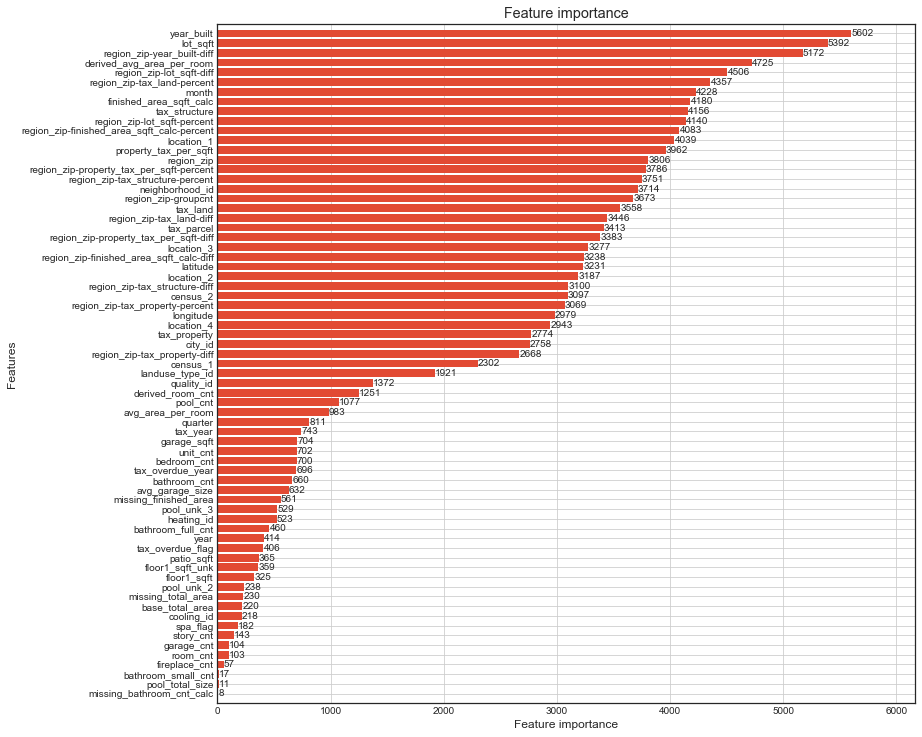

In [10]:
# Plot LightGBM feature importance
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

# Train on all data + Make predictions

In [11]:
# Train LightGBM on all given training data (preparing for submission)
del params['early_stopping_rounds']
params['num_boost_round'] = 1250  # roughly chosen based on public leaderboard score
print(params)

outlier_threshold = 0.4
mask = (abs(lgb_y) <= outlier_threshold)
lgb_X = lgb_X[mask, :]
lgb_y = lgb_y[mask]

lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, verbose_eval=True, categorical_feature=categorical_indices)

# Sanity check: make sure the model score is reasonable on a small portion of the data
print("score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

{'objective': 'regression', 'metric': 'mae', 'num_threads': 4, 'boosting_type': 'gbdt', 'num_boost_round': 1250, 'learning_rate': 0.003, 'num_leaves': 127, 'min_data': 150, 'min_hessian': 0.001, 'max_depth': -1, 'max_bin': 255, 'sub_feature': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 50, 'min_data_per_group': 100, 'cat_smooth': 15.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'feature_fraction_seed': 2, 'bagging_seed': 3}
lgb_X: (164299, 69)
lgb_y: (164299,)


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21, 66, 67, 68]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


score: 6.737666655002994


In [12]:
"""
    Helper method that prepares 2016 and 2017 properties features for inference
"""
def transform_test_features(features_2016, features_2017):
    test_features_2016 = lgb_drop_features(features_2016)
    test_features_2017 = lgb_drop_features(features_2017)
    
    test_features_2016['year'] = 0
    test_features_2017['year'] = 1
    
    # 11 & 12 lead to unstable results, probably due to the fact that there are few training examples for them
    test_features_2016['month'] = 10
    test_features_2017['month'] = 10
    
    test_features_2016['quarter'] = 4
    test_features_2017['quarter'] = 4
    
    return test_features_2016, test_features_2017

"""
    Helper method that makes predictions on the test set and exports results to csv file
    'models' is a list of models for ensemble prediction (len=1 means using just a single model)
"""
def predict_and_export(models, features_2016, features_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = features_2016.parcelid
    submission_2017['ParcelId'] = features_2017.parcelid
    
    test_features_2016, test_features_2017 = transform_test_features(features_2016, features_2017)
    
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(test_features_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(test_features_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission, pred_2016, pred_2017  # Return the results so that we can analyze or sanity check it

In [13]:
%%time
file_name = 'submission/final_lgb_single.csv'
submission, pred_2016, pred_2017 = predict_and_export([model], features_2016, features_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0012  0.0012  0.0012  0.0061  0.0061  0.0061
1  10759547  0.0018  0.0018  0.0018  0.0036  0.0036  0.0036
2  10843547  0.0303  0.0303  0.0303  0.0399  0.0399  0.0399
3  10859147  0.0356  0.0356  0.0356  0.0326  0.0326  0.0326
4  10879947  0.0007  0.0007  0.0007  0.0006  0.0006  0.0006
CPU times: user 28min 19s, sys: 11.4 s, total: 28min 31s
Wall time: 7min 38s


# Ensemble Training and Prediction

In [ ]:
# Remove outliers (if any) from training data
outlier_threshold = 0.4
mask = (abs(lgb_y) <= outlier_threshold)
lgb_X = lgb_X[mask, :]
lgb_y = lgb_y[mask]
lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

del params['early_stopping_rounds']
del params['feature_fraction_seed']
del params['bagging_seed']
params['num_boost_round'] = 1250

# Train multiple models
bags = 5
models = []
for i in range(bags):
    print("Start training model {}".format(i))
    params['seed'] = i
    np.random.seed(42)
    random.seed(36)
    model = lgb.train(params, lgb_train_set, verbose_eval=False, categorical_feature=categorical_indices)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_val) - y_val).mean() * 100))

# Save the trained models to disk
save_models(models)

# models = load_models(['checkpoints/lgb_' + str(i) for i in range(5)])  # load pretrained models

In [ ]:
# Make predictions and export results
file_name = 'submission/final_lgb_ensemble_x5.csv'
submission, pred_2016, pred_2017 = predict_and_export(models, features_2016, features_2017, file_name)